In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [2]:
from einops import rearrange, repeat

In [6]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x, *args, **kwargs):
        x = self.norm(x)
        return self.fn(x, *args, **kwargs)

In [7]:
class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim = -1)
        return x * F.gelu(gates)

class FeedForward(nn.Module):
    def __init__(self, dim, mult = 4, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult * 2),
            GEGLU(),
            nn.Dropout(dropout),
            nn.Linear(dim * mult, dim)
        )

    def forward(self, x):
        return self.net(x)

In [8]:
# attention

def attn(q, k, v):
    sim = einsum('b i d, b j d -> b i j', q, k)
    attn = sim.softmax(dim = -1)
    out = einsum('b i j, b j d -> b i d', attn, v)
    return out

class Attention(nn.Module):
    def __init__(
        self,
        dim,
        dim_head = 64,
        heads = 8,
        dropout = 0.
    ):
        super().__init__()
        self.heads = heads
        self.scale = dim_head ** -0.5
        inner_dim = dim_head * heads

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x, einops_from, einops_to, **einops_dims):
        h = self.heads
        q, k, v = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h = h), (q, k, v))

        q *= self.scale

        # splice out classification token at index 1
        (cls_q, q_), (cls_k, k_), (cls_v, v_) = map(lambda t: (t[:, 0:1], t[:, 1:]), (q, k, v))

        # let classification token attend to key / values of all patches across time and space
        cls_out = attn(cls_q, k, v)

        # rearrange across time or space
        q_, k_, v_ = map(lambda t: rearrange(t, f'{einops_from} -> {einops_to}', **einops_dims), (q_, k_, v_))

        # expand cls token keys and values across time or space and concat
        r = q_.shape[0] // cls_k.shape[0]
        cls_k, cls_v = map(lambda t: repeat(t, 'b () d -> (b r) () d', r = r), (cls_k, cls_v))

        k_ = torch.cat((cls_k, k_), dim = 1)
        v_ = torch.cat((cls_v, v_), dim = 1)

        # attention
        out = attn(q_, k_, v_)

        # merge back time or space
        out = rearrange(out, f'{einops_to} -> {einops_from}', **einops_dims)

        # concat back the cls token
        out = torch.cat((cls_out, out), dim = 1)

        # merge back the heads
        out = rearrange(out, '(b h) n d -> b n (h d)', h = h)

        # combine heads out
        return self.to_out(out)


In [9]:
class TimeSformer(nn.Module):
    def __init__(
        self,
        *,
        dim,
        num_frames,
        num_classes,
        image_size = 224,
        patch_size = 16,
        channels = 3,
        depth = 12,
        heads = 8,
        dim_head = 64,
        attn_dropout = 0.,
        ff_dropout = 0.
    ):
        super().__init__()
        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_size // patch_size) ** 2
        num_positions = num_frames * num_patches
        patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size
        self.to_patch_embedding = nn.Linear(patch_dim, dim)
        self.pos_emb = nn.Embedding(num_positions + 1, dim)
        self.cls_token = nn.Parameter(torch.randn(1, dim))

        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, dim_head = dim_head, heads = heads, dropout = attn_dropout)), # Time attention
                PreNorm(dim, Attention(dim, dim_head = dim_head, heads = heads, dropout = attn_dropout)), # Spatial attention
                PreNorm(dim, FeedForward(dim, dropout = ff_dropout)) # Feed Forward
            ]))

        self.to_out = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, video):
        b, f, _, h, w, *_, device, p = *video.shape, video.device, self.patch_size
        assert h % p == 0 and w % p == 0, f'height {h} and width {w} of video must be divisible by the patch size {p}'

        n = (h // p) * (w // p)
        video = rearrange(video, 'b f c (h p1) (w p2) -> b (f h w) (p1 p2 c)', p1 = p, p2 = p)
        
        tokens = self.to_patch_embedding(video)

        cls_token = repeat(self.cls_token, 'n d -> b n d', b = b)
        x =  torch.cat((cls_token, tokens), dim = 1)
        x += self.pos_emb(torch.arange(x.shape[1], device = device))

        for (time_attn, spatial_attn, ff) in self.layers:
            x = time_attn(x, 'b (f n) d', '(b n) f d', n = n) + x
            x = spatial_attn(x, 'b (f n) d', '(b f) n d', f = f) + x
            x = ff(x) + x

        cls_token = x[:, 0]
        
        return self.to_out(cls_token)

In [ ]:
#Parameters
DIM = 224
IMAGE_SIZE = 224
PATCH_SIZE = 16
NUM_CLASSES = 2
NUM_FRAMES = 20
DEPTH = 12
HEADS = 8
DIM_HEAD = 64
ATTN_DROPOUT = 0.1
FF_DROPOUT = 0.1
ITERATIONS = 20


model = torch.nn.Sequential(TimeSformer(dim = DIM, image_size = IMAGE_SIZE, patch_size = PATCH_SIZE, num_frames = NUM_FRAMES, num_classes = NUM_CLASSES, depth = DEPTH, heads = HEADS, dim_head = DIM_HEAD, attn_dropout = ATTN_DROPOUT, ff_dropout = FF_DROPOUT), nn.Softmax(dim=1))
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-4

In [3]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os


class VideoDataset(Dataset):
    def __init__(self, features_dir, groundtruth_dir, mapping_file, bundle_file, transform=None):
        self.features_dir = features_dir
        self.groundtruth_dir = groundtruth_dir
        self.transform = transform

        # Load the mapping file
        self.action_to_id = {}
        with open(mapping_file, 'r') as f:
            for line in f:
                action_id, action = line.strip().split()
                self.action_to_id[action] = int(action_id)

        # Load the bundle file
        with open(bundle_file, 'r') as f:
            self.video_files = [line.strip()[:-4] for line in f]

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_file = self.video_files[idx]

        # Load features
        feature_path = os.path.join(self.features_dir, video_file + '.npy')
        features = np.load(feature_path)
        
        # Load ground truth
        groundtruth_path = os.path.join(self.groundtruth_dir, video_file + '.txt')
        with open(groundtruth_path, 'r') as f:
            groundtruth = [self.action_to_id[line.strip()] for line in f]
        
        if self.transform:
            features = self.transform(features)
        
        
        return torch.tensor(features, dtype=torch.float32).squeeze().transpose(0, 1), torch.tensor(groundtruth, dtype=torch.long)

    

def collate_fn_train(batch):
    # Extract features and labels
    features, labels = zip(*batch)
    
    # Determine the maximum number of frames in any single example in the batch
    # max_frames = max(f.shape[2] for f in features)
    max_frames = max(f.shape[2] for f, _ in batch)
    # print(max_frames)
    padded_features = []
    padded_labels = []
    
    for f, l in zip(features, labels):
        # Number of frames to pad for this sample
        num_pad_frames = max_frames - f.shape[2]
        # print(num_pad_frames)
        # Pad features correctly on the frame dimension
        padded_feature = torch.squeeze(F.pad(f, (0, num_pad_frames), "constant", 0))


        # print(f"trans = {padded_feature.shape}")
        padded_feature = padded_feature.transpose(0, 1)

        padded_features.append(padded_feature)

        # Assuming labels should be a vector where each entry corresponds to a frame
        # This assumes l is a tensor with size equal to the number of frames in f
        padded_label = F.pad(l, (0, num_pad_frames), "constant", -1)  # Using -1 as padding value for labels
        padded_labels.append(padded_label)
        
    # Stack the padded features and labels to create a new batch
    padded_features = torch.stack(padded_features)
    padded_labels = torch.stack(padded_labels)
    
    return padded_features, padded_labels

def collate_fn_test(batch):
    # Determine the maximum length in the batch for padding
    max_len = max(f.shape[1] for f, _ in batch)  # assuming the variable dimension is the second one

    padded_features, padded_labels = [], []

    for features, labels in batch:
        # Padding features
        padding = (0, max_len - features.shape[1])  # padding on the second dimension
        padded_feature = F.pad(features, padding, 'constant', 0).T
        padded_features.append(padded_feature)

        # Padding labels
        # Assume labels are one-dimensional and need padding to match features' time dimension
        label_padding = (0, max_len - len(labels))
        padded_labels.append(F.pad(labels, label_padding, 'constant', -1))  # Using -1 for padding labels

    return torch.stack(padded_features), torch.stack(padded_labels)


In [4]:
import torch
import torch.nn as nn
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** (-0.5)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)
        q = q * self.scale
        dots = torch.einsum('b h i d, b h j d -> b h i j', q, k)
        attn = dots.softmax(dim=-1)
        out = torch.einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class CustomTransformerEncoderLayer(nn.Module):
    def __init__(self, dim, heads, dim_head, dropout):
        super().__init__()
        self.attn = Attention(dim, heads, dim_head, dropout)
        self.ff = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout)
        )
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.ff(self.norm2(x))
        return x

class ModifiedTimeSformer(nn.Module):
    def __init__(self, dim, num_classes, depth, heads, dim_head, attn_dropout, ff_dropout):
        super().__init__()
        self.to_feature_embedding = nn.Linear(2048, dim)
        self.layers = nn.ModuleList([CustomTransformerEncoderLayer(dim, heads, dim_head, attn_dropout) for _ in range(depth)])
        self.to_out = nn.Linear(dim, num_classes)
        self.dim = dim

    def forward(self, x):
        num_frames = x.shape[1]
        x = self.to_feature_embedding(x)  # [batch_size, num_frames, dim]
        pos_embedding = self.get_pos_embedding(num_frames, self.dim).expand(x.size(0), -1, -1)  # Expand for batch size
        x += pos_embedding  # Add positional embedding

        for layer in self.layers:
            x = layer(x)  # Apply each transformer layer

        x = self.to_out(x)  # Apply the output layer to all frames
        return x

    @staticmethod
    def get_pos_embedding(num_frames, dim):
        return nn.Parameter(torch.randn(1, num_frames, dim))  # Dynamic positional encoding based on the number of frames


/home/s44vchai/miniconda3/envs/sheet02env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import v2


# Parameters
root_dataset = 'data/'
features_dir = root_dataset + 'features'
groundtruth_dir = root_dataset + 'groundTruth'
mapping_file = root_dataset + 'mapping.txt'
train_bundle_file = root_dataset + 'train.bundle'
test_bundle_file = root_dataset + 'test.bundle'

transforms = v2.Compose([
    # v2.Resize(size=(224, 224)),
    v2.ToTensor(),
    # v2.RandomHorizontalFlip(p=0.5),
    # v2.ToDtype(torch.float32, scale=True),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

batch_size = 16
# Create dataset and dataloader for training
train_dataset = VideoDataset(features_dir, groundtruth_dir, mapping_file, train_bundle_file, transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)#, collate_fn=collate_fn_train)

# Create dataset and dataloader for testing
test_dataset = VideoDataset(features_dir, groundtruth_dir, mapping_file, test_bundle_file)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)#, collate_fn=collate_fn_test)


/home/s44vchai/miniconda3/envs/sheet02env/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os

def new_train(model, criterion, optimizer, num_epochs, train_loader, test_loader, device, model_save_path):
    losses = {'train': [], 'val': []}
    accuracies = {'train': [], 'val': []}
    best_val_accuracy = -5  # Initialize best validation accuracy for model saving

    sftmx = nn.Softmax(dim=2)
    for epoch in range(5, num_epochs):
        # Initialize tqdm loop with additional display info
        train_loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training")
        val_loop = tqdm(test_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation")

        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loop:
            # print(f'TRAIN inputs, labels = {inputs.shape, labels.shape}')
            inputs, labels = inputs.to(device), labels.to(device)
            # labels = labels.long() 

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            outputs = outputs.transpose(1, 2)

            # print(outputs)
            # Calculate loss
            loss = criterion(outputs, labels)

            # Accumulate loss and backpropagate
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += torch.numel(labels[labels != -1])

            # Update tqdm loop for training phase
            train_loop.set_postfix(loss=loss.item(), acc=float(correct_train) / total_train)

        # Average loss and accuracy across the epoch for training
        epoch_train_loss = train_loss / total_train
        epoch_train_accuracy = correct_train / total_train
        losses['train'].append(epoch_train_loss)
        accuracies['train'].append(epoch_train_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loop:
                inputs, labels = inputs.to(device), labels.to(device)

                # print(f'VALIDATION inputs, labels = {inputs.shape, labels.shape}')
                outputs = model(inputs)
                outputs = outputs.transpose(1, 2)

                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += torch.numel(labels[labels != -1])

                # Update tqdm loop for validation phase
                val_loop.set_postfix(loss=loss.item(), acc=float(correct_val) / total_val)

        # Average validation loss and accuracy
        epoch_val_loss = val_loss / total_val
        epoch_val_accuracy = correct_val / total_val
        losses['val'].append(epoch_val_loss)
        accuracies['val'].append(epoch_val_accuracy)

        # Save model if validation accuracy improves
        if epoch_val_accuracy > best_val_accuracy:
            best_val_accuracy = epoch_val_accuracy
            torch.save(model.state_dict(), os.path.join(model_save_path, f'best_model_epoch_{epoch+1}.pth'))
            print(f"Model improved and saved: Val Acc = {epoch_val_accuracy:.4f}")

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f}")

    return {'losses': losses, 'accuracies': accuracies}


In [9]:
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")

# Model parameters
learning_rate = 0.001
num_classes = max(int(line.split()[0]) for line in open('data/mapping.txt')) + 1 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_dim = 256
mlp_dim = 2048
max_frames = 9741
num_patches = 16

model = ModifiedTimeSformer(dim=512, num_classes=48, depth=6, heads=8, dim_head=64, attn_dropout=0.1, ff_dropout=0.1)
model.load_state_dict(torch.load('models/best_model_epoch_5.pth'))


# criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss(ignore_index=-1) 
# criterion = torch.nn.MSELoss(reduction='sum')
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# torch.set_grad_enabled(True)

# Training loop
num_epochs = 19
# train(model=model, criterion=criterion, optimizer=optimizer, num_epochs=num_epochs, train_loader=train_loader, test_loader=test_loader, device=device, batch_size=batch_size)
# result = train(model=model, criterion=criterion, optimizer=optimizer, num_epochs=num_epochs, train_loader=train_loader, test_loader=test_loader, device=device, batch_size=batch_size, num_classes=num_classes)
result = new_train(model, criterion, optimizer, num_epochs, train_loader, test_loader, device, 'models/')
print(result)

Epoch 6/19 - Training:   0%|                                                                                                | 0/733 [00:00<?, ?it/s]



Epoch 6/19 - Training:  33%|█████████████████████▏                                          | 243/733 [02:43<27:36,  3.38s/it, acc=0.524, loss=3.01]IOStream.flush timed out
IOStream.flush timed out
Epoch 6/19 - Training: 100%|████████████████████████████████████████████████████████████████| 733/733 [08:22<00:00,  1.46it/s, acc=0.526, loss=1.28]


















































































































































































































































































































































































Epoch 6/19 - Validation: 100%|██████████████████████████████████████████████████████████████| 128/128 [08:46<00:00,  4.11s/it, acc=0.548, loss=1.16]


Model improved and saved: Val Acc = 0.5481
Epoch 6/19, Train Loss: 0.0008, Train Acc: 0.5261, Val Loss: 0.0011, Val Acc: 0.5481


Epoch 7/19 - Validation: 100%|██████████████████████████████████████████████████████████████| 128/128 [07:50<00:00,  3.68s/it, acc=0.555, loss=3.97]


Model improved and saved: Val Acc = 0.5549
Epoch 7/19, Train Loss: 0.0009, Train Acc: 0.5216, Val Loss: 0.0010, Val Acc: 0.5549


Epoch 8/19 - Validation: 100%|██████████████████████████████████████████████████████████████| 128/128 [07:41<00:00,  3.61s/it, acc=0.514, loss=3.66]


Epoch 8/19, Train Loss: 0.0006, Train Acc: 0.5883, Val Loss: 0.0011, Val Acc: 0.5139


Epoch 9/19 - Validation: 100%|██████████████████████████████████████████████████████████████| 128/128 [07:57<00:00,  3.73s/it, acc=0.465, loss=3.05]


Epoch 9/19, Train Loss: 0.0012, Train Acc: 0.5216, Val Loss: 0.0015, Val Acc: 0.4646


Epoch 10/19 - Validation: 100%|█████████████████████████████████████████████████████████████| 128/128 [07:41<00:00,  3.61s/it, acc=0.569, loss=1.31]


Model improved and saved: Val Acc = 0.5688
Epoch 10/19, Train Loss: 0.0006, Train Acc: 0.6094, Val Loss: 0.0010, Val Acc: 0.5688


Epoch 11/19 - Validation: 100%|████████████████████████████████████████████████████████████| 128/128 [07:46<00:00,  3.64s/it, acc=0.536, loss=0.855]


Epoch 11/19, Train Loss: 0.0010, Train Acc: 0.5673, Val Loss: 0.0012, Val Acc: 0.5365


Epoch 12/19 - Validation: 100%|█████████████████████████████████████████████████████████████| 128/128 [08:11<00:00,  3.84s/it, acc=0.442, loss=2.73]


Epoch 12/19, Train Loss: 0.0023, Train Acc: 0.5266, Val Loss: 0.0014, Val Acc: 0.4418


Epoch 13/19 - Validation: 100%|█████████████████████████████████████████████████████████████| 128/128 [09:46<00:00,  4.58s/it, acc=0.535, loss=2.86]


Epoch 13/19, Train Loss: 0.0101, Train Acc: 0.3934, Val Loss: 0.0014, Val Acc: 0.5348


Epoch 14/19 - Validation: 100%|█████████████████████████████████████████████████████████████| 128/128 [08:10<00:00,  3.83s/it, acc=0.529, loss=5.51]


Epoch 14/19, Train Loss: 0.0014, Train Acc: 0.5040, Val Loss: 0.0013, Val Acc: 0.5288


Epoch 15/19 - Validation: 100%|████████████████████████████████████████████████████████████| 128/128 [07:40<00:00,  3.60s/it, acc=0.565, loss=0.556]


Epoch 15/19, Train Loss: 0.0007, Train Acc: 0.5860, Val Loss: 0.0011, Val Acc: 0.5652


Epoch 16/19 - Validation: 100%|█████████████████████████████████████████████████████████████| 128/128 [07:39<00:00,  3.59s/it, acc=0.494, loss=1.52]


Epoch 16/19, Train Loss: 0.0006, Train Acc: 0.6203, Val Loss: 0.0013, Val Acc: 0.4935


Epoch 17/19 - Validation: 100%|█████████████████████████████████████████████████████████████| 128/128 [07:40<00:00,  3.60s/it, acc=0.506, loss=6.67]


Epoch 17/19, Train Loss: 0.0006, Train Acc: 0.6149, Val Loss: 0.0015, Val Acc: 0.5062


Epoch 18/19 - Validation: 100%|███████████████████████████████████████████████████████████████| 128/128 [08:54<00:00,  4.18s/it, acc=0.5, loss=3.35]


Epoch 18/19, Train Loss: 0.0023, Train Acc: 0.5086, Val Loss: 0.0015, Val Acc: 0.5001


Epoch 19/19 - Validation: 100%|█████████████████████████████████████████████████████████████| 128/128 [08:54<00:00,  4.18s/it, acc=0.525, loss=1.41]

Epoch 19/19, Train Loss: 0.0018, Train Acc: 0.5079, Val Loss: 0.0012, Val Acc: 0.5249
{'losses': {'train': [0.0008061888503581884, 0.000861254566717052, 0.0006481212794543638, 0.0012464715557130824, 0.000600742070545433, 0.0010280668598598637, 0.0023370192508089995, 0.010086385378737335, 0.0013932032457041465, 0.0006706000208177369, 0.0005957721285583395, 0.0006095738793666407, 0.002317543067489249, 0.0017920958085240626], 'val': [0.0010870323727984145, 0.0010337277122633012, 0.0010939755636519676, 0.001456473726484187, 0.0009593397638414952, 0.0011572002741346687, 0.001356450553001675, 0.0013622942416495057, 0.001336265843518939, 0.0011185817270956628, 0.0012705271658255692, 0.0015118764912802703, 0.0014862546665176677, 0.0011923971330731027]}, 'accuracies': {'train': [0.5260748981592648, 0.5216425137416649, 0.588301291293338, 0.5216133040437456, 0.6094341332546419, 0.5672957736562977, 0.5265879402893857, 0.39341868057547597, 0.5039616589011312, 0.5860379141878993, 0.620340585077739, 

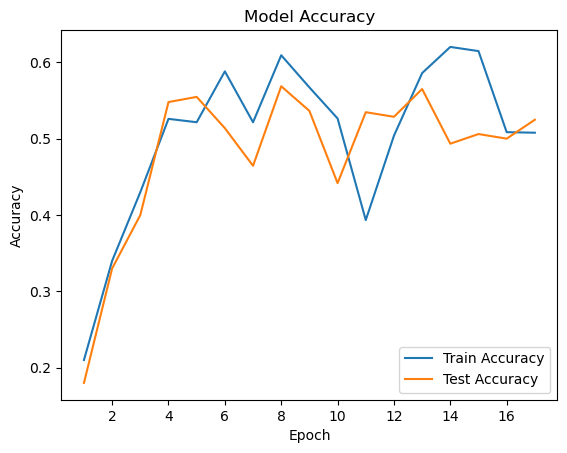

In [21]:
import matplotlib.pyplot as plt
acc_train = [0.21, 0.34, 0.43] + result["accuracies"]["train"]
acc_test = [0.18, 0.33, 0.4] + result["accuracies"]["val"]
epochs = [i for i in range(1, 18)]

plt.plot(epochs, acc_train, label='Train Accuracy')
plt.plot(epochs, acc_test, label='Test Accuracy')  

plt.title('TimeSformer Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()

plt.show()
 